# Análisis Estadístico-Ecológico: Camino 1
## Modelo Gamma GLM para densidad ponderada vs apertura del dosel

Este notebook implementa el **primer camino** descrito en `procedimiento.md`:
- Modelo Gamma GLM con enlace log
- Variable respuesta: `densidad_ponderada`
- Variable explicatoria: `apertura_s` (apertura del dosel estandarizada)
- Validación tipo DHARMa (QQ-plot, residuos, heterocedasticidad, puntos influyentes)

## 1. Importar librerías necesarias

In [1]:
# 1. Librerías básicas
import pandas as pd
import numpy as np

# 2. Graficación
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Modelos estadísticos
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 4. Pruebas estadísticas
from statsmodels.stats.diagnostic import het_breuschpagan
import scipy.stats as st

# 5. Estandarización
from sklearn.preprocessing import StandardScaler

print("✓ Librerías importadas correctamente")

✓ Librerías importadas correctamente


## 2. Cargar y preparar los datos

Cargamos `resultados.xlsx` y calculamos:
- `densidad_ponderada`: densidad de inflorescencias ajustada
- `apertura`: proporción de área expuesta (Prc_expuesto)

In [2]:
# Cargar datos desde resultados.xlsx
df = pd.read_excel("resultados.xlsx")

# Eliminar la fila de totales si existe
df = df[df["Unidad"] != "Total"].copy()


# Calcular densidad ponderada usando N_flor directamente
df["densidad_ponderada"] = df["N_flor"] / (df["Total"] / 10000)  # por m²

# La apertura es la proporción de área expuesta (Prc_expuesto)
df["apertura"] = df["Prc_expuesto"]

# Mostrar primeras filas
print("Datos cargados:")
print(df[["Unidad", "densidad_ponderada", "apertura"]].head(10))
print(f"\nTotal de observaciones: {len(df)}")

Datos cargados:
  Unidad  densidad_ponderada  apertura
0      1           40.497769  0.823955
1      2           29.823562  0.841026
2      3            6.294811  0.859549
3      4           37.958269  0.832559
4      5           37.356142  0.631171
5      6            0.239044  0.497582
6      7           65.515438  0.181998
7      8          117.241695  0.749469
8      9           29.721378  0.580353
9     10           37.625405  0.889373

Total de observaciones: 12


## 3. Estandarización de la variable predictora

Estandarizamos `apertura` para mejorar la interpretación y estabilidad del modelo.

In [3]:
scaler = StandardScaler()
df["apertura_s"] = scaler.fit_transform(df[["apertura"]])

print("Estadísticas de apertura_s:")
print(df["apertura_s"].describe())

Estadísticas de apertura_s:
count    1.200000e+01
mean     1.110223e-16
std      1.044466e+00
min     -2.606382e+00
25%     -5.056801e-01
50%      5.040315e-01
75%      6.666773e-01
max      9.735333e-01
Name: apertura_s, dtype: float64


In [4]:
model = smf.glm(
    formula="densidad_ponderada ~ apertura_s",
    data=df,
    family=sm.families.Gamma(sm.families.links.Log())
).fit()

# Calcular R² para GLM (McFadden y Nagelkerke)
# Modelo nulo (solo intercepto)
model_null = smf.glm(
    formula="densidad_ponderada ~ 1",
    data=df,
    family=sm.families.Gamma(sm.families.links.Log())
).fit()

# R² de McFadden
llf_model = model.llf  # log-likelihood del modelo completo
llf_null = model_null.llf  # log-likelihood del modelo nulo
r2_mcfadden = 1 - (llf_model / llf_null)

# R² de Nagelkerke (ajustado)
n = len(df)
r2_nagelkerke = (1 - np.exp((llf_null - llf_model) * (2/n))) / (1 - np.exp(llf_null * (2/n)))

print("="*80)
print("RESUMEN DEL MODELO GAMMA GLM")
print("="*80)
print(model.summary())
print("\n" + "="*80)
print("BONDAD DE AJUSTE (R²)")
print("="*80)
print(f"R² de McFadden:   {r2_mcfadden:.4f} ({r2_mcfadden*100:.2f}%)")
print(f"R² de Nagelkerke: {r2_nagelkerke:.4f} ({r2_nagelkerke*100:.2f}%)")
if r2_mcfadden >= 0.60 or r2_nagelkerke >= 0.60:
    print("\n✔ AJUSTE ACEPTABLE (R² ≥ 60%)")
else:
    print(f"\n⚠ AJUSTE INSUFICIENTE (R² < 60%)")
print("="*80)

RESUMEN DEL MODELO GAMMA GLM
                 Generalized Linear Model Regression Results                  
Dep. Variable:     densidad_ponderada   No. Observations:                   12
Model:                            GLM   Df Residuals:                       10
Model Family:                   Gamma   Df Model:                            1
Link Function:                    log   Scale:                          8.4647
Method:                          IRLS   Log-Likelihood:                -74.155
Date:                Wed, 03 Dec 2025   Deviance:                       44.523
Time:                        20:05:13   Pearson chi2:                     84.6
No. Iterations:                   100   Pseudo R-squ. (CS):            0.07623
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.3253  

/var/home/beto/workspace/bosque/.venv/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/var/home/beto/workspace/bosque/.venv/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [5]:
beta = model.params["apertura_s"]
exp_beta = np.exp(beta)

print("="*80)
print("INTERPRETACIÓN DEL COEFICIENTE")
print("="*80)
print(f"β (apertura_s) = {beta:.4f}")
print(f"exp(β) = {exp_beta:.4f}")
print(f"\nInterpretación:")
print(f"Por cada aumento de 1 desviación estándar en apertura del dosel,")
print(f"la densidad ponderada cambia en un factor de {exp_beta:.3f}")
print(f"Es decir, {'aumenta' if exp_beta > 1 else 'disminuye'} un {abs((exp_beta - 1) * 100):.1f}%")

INTERPRETACIÓN DEL COEFICIENTE
β (apertura_s) = 0.4639
exp(β) = 1.5903

Interpretación:
Por cada aumento de 1 desviación estándar en apertura del dosel,
la densidad ponderada cambia en un factor de 1.590
Es decir, aumenta un 59.0%


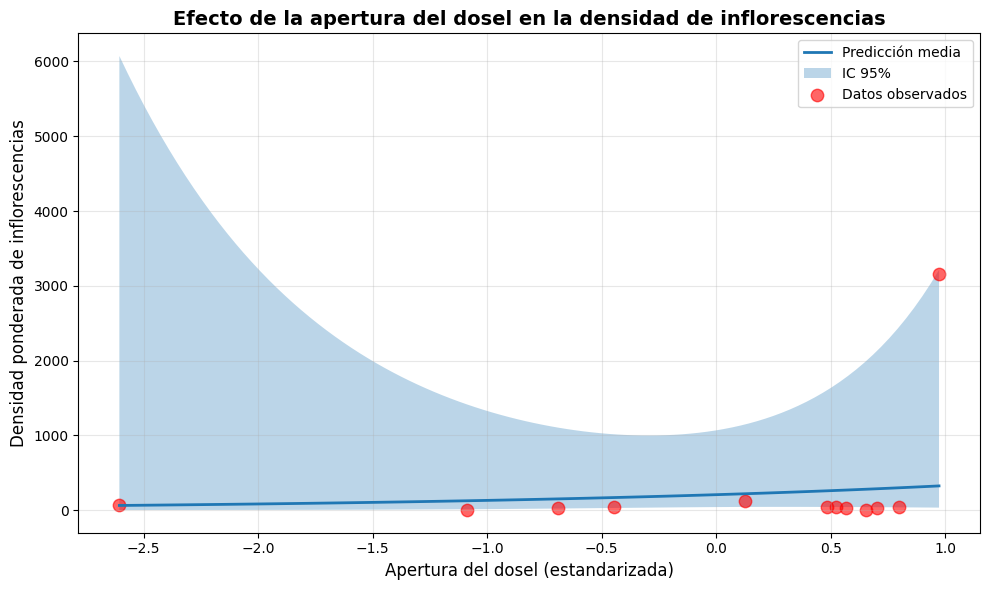

In [6]:
# Crear rango de valores de apertura estandarizada
new = pd.DataFrame({
    "apertura_s": np.linspace(df.apertura_s.min(), df.apertura_s.max(), 100)
})

# Predicciones con intervalo de confianza
pred = model.get_prediction(new)
pred_summary = pred.summary_frame()

# Gráfica
plt.figure(figsize=(10, 6))
plt.plot(new.apertura_s, pred_summary["mean"], label="Predicción media", linewidth=2)
plt.fill_between(
    new.apertura_s,
    pred_summary["mean_ci_lower"],
    pred_summary["mean_ci_upper"],
    alpha=0.3, label="IC 95%"
)

# Añadir puntos observados
plt.scatter(df.apertura_s, df.densidad_ponderada, color='red', alpha=0.6, s=80, label="Datos observados")

plt.xlabel("Apertura del dosel (estandarizada)", fontsize=12)
plt.ylabel("Densidad ponderada de inflorescencias", fontsize=12)
plt.title("Efecto de la apertura del dosel en la densidad de inflorescencias", fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [7]:
resid_dev = model.resid_deviance.copy()
fitted = model.fittedvalues.copy()

print("Estadísticas de residuos:")
print(f"Media: {resid_dev.mean():.4f}")
print(f"Desviación estándar: {resid_dev.std():.4f}")

Estadísticas de residuos:
Media: -1.0579
Desviación estándar: 1.6812


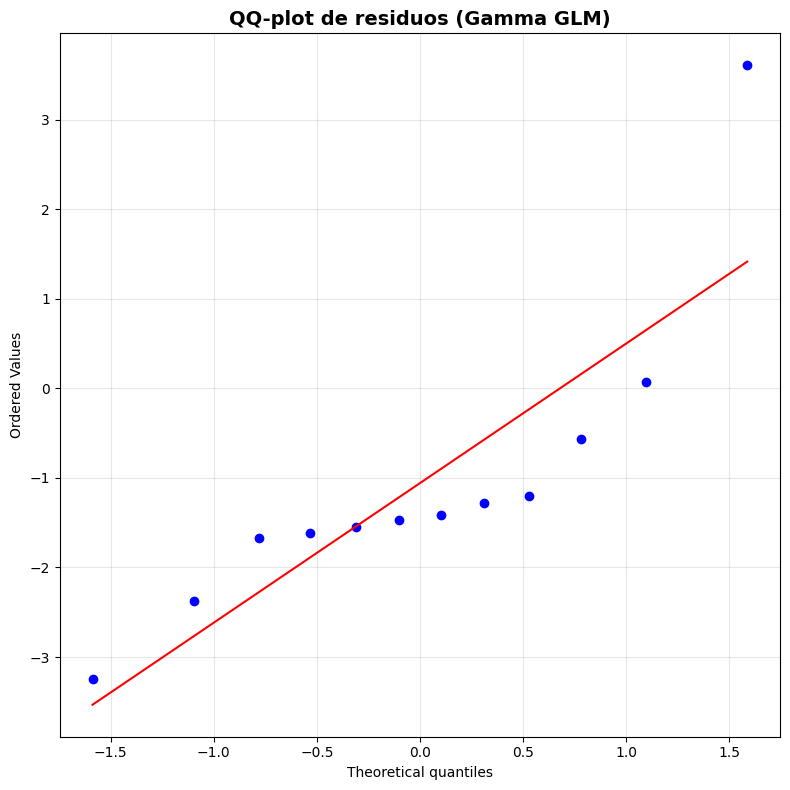

In [8]:
plt.figure(figsize=(8, 8))
st.probplot(resid_dev, dist="norm", plot=plt)
plt.title("QQ-plot de residuos (Gamma GLM)", fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

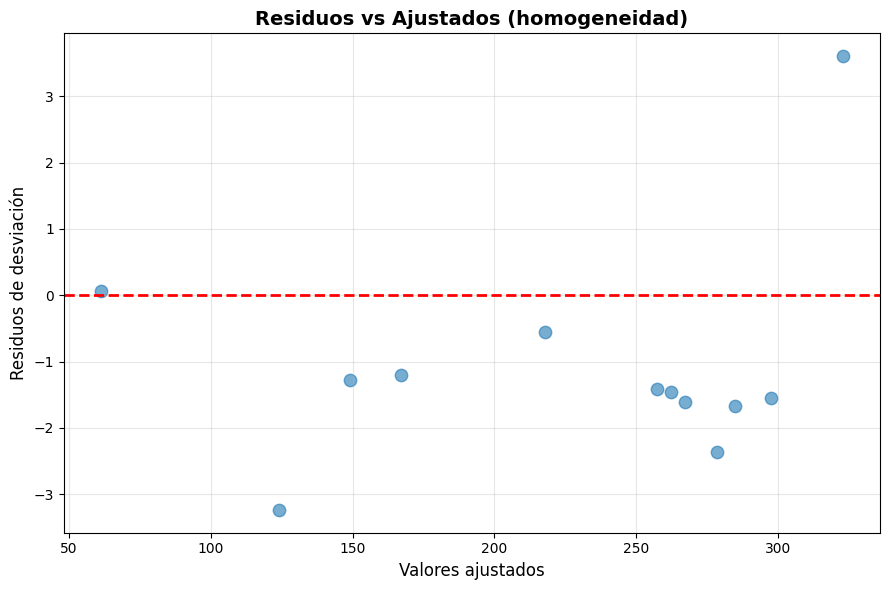

In [9]:
plt.figure(figsize=(9, 6))
plt.scatter(fitted, resid_dev, s=80, alpha=0.6)
plt.axhline(0, color="red", linestyle="--", linewidth=2)
plt.xlabel("Valores ajustados", fontsize=12)
plt.ylabel("Residuos de desviación", fontsize=12)
plt.title("Residuos vs Ajustados (homogeneidad)", fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
bp = het_breuschpagan(resid_dev, sm.add_constant(fitted))

print("="*80)
print("TEST DE BREUSCH-PAGAN (Heterocedasticidad)")
print("="*80)
print(f"Estadístico LM: {bp[0]:.4f}")
print(f"p-value: {bp[1]:.4f}")

if bp[1] > 0.05:
    print("\n✔ No se detecta heterocedasticidad fuerte (p > 0.05)")
else:
    print("\n⚠ Posible heterocedasticidad detectada (p < 0.05). Revisar modelo.")

TEST DE BREUSCH-PAGAN (Heterocedasticidad)
Estadístico LM: 0.8195
p-value: 0.3653

✔ No se detecta heterocedasticidad fuerte (p > 0.05)


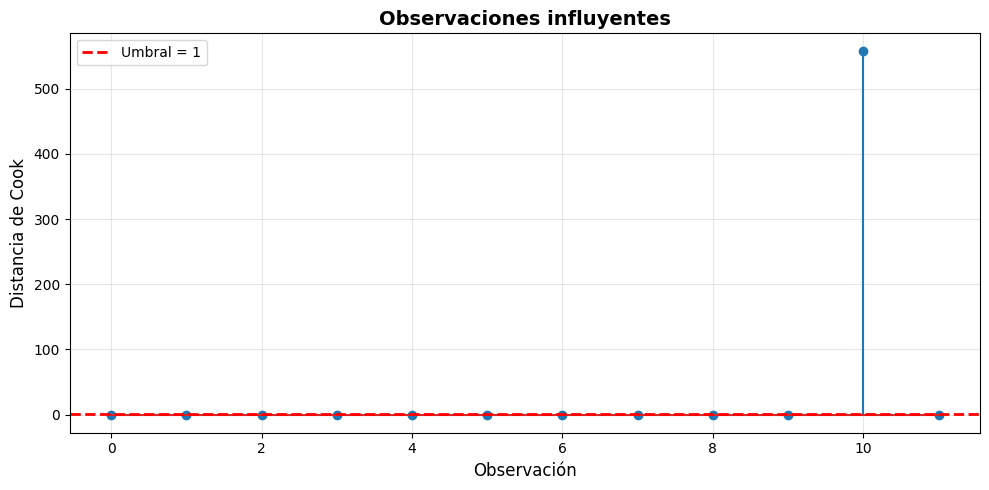


Observaciones con Cook's distance > 1: [np.int64(10)]


In [11]:
influence = model.get_influence()
cooks = influence.cooks_distance[0]

plt.figure(figsize=(10, 5))
plt.stem(cooks)
plt.axhline(1, color='red', linestyle='--', linewidth=2, label='Umbral = 1')
plt.xlabel("Observación", fontsize=12)
plt.ylabel("Distancia de Cook", fontsize=12)
plt.title("Observaciones influyentes", fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

high_influence = np.where(cooks > 1)[0]
print(f"\nObservaciones con Cook's distance > 1: {list(high_influence)}")
if len(high_influence) == 0:
    print("✔ No hay observaciones extremadamente influyentes")

In [12]:
print("="*80)
print("INTERPRETACIÓN FINAL DEL MODELO")
print("="*80)

p_value = model.pvalues["apertura_s"]

if p_value < 0.05:
    print("✔ La apertura del dosel es un predictor SIGNIFICATIVO de la densidad ponderada")
    print(f"  (p = {p_value:.4f} < 0.05)")
else:
    print("⚠ La apertura del dosel NO es significativa")
    print(f"  (p = {p_value:.4f} > 0.05)")
    print("  Interpretación con cautela.")

print(f"\nCoeficiente β = {beta:.4f}")
print(f"Factor multiplicativo exp(β) = {exp_beta:.4f}")

if beta > 0:
    print(f"\n→ La apertura del dosel INCREMENTA la densidad de inflorescencias")
    print(f"  Un aumento de 1 DE en apertura se traduce en un aumento del {(exp_beta - 1) * 100:.1f}%")
else:
    print(f"\n→ Las zonas más SOMBREADAS presentan mayor densidad")
    print(f"  Un aumento de 1 DE en apertura reduce la densidad en un {(1 - exp_beta) * 100:.1f}%")

print("\n" + "="*80)
print("VALIDACIÓN DEL MODELO")
print("="*80)
print("Revisar:")
print("  • QQ-plot para normalidad de residuos")
print("  • Residuos vs Ajustados para homogeneidad")
print(f"  • Test de Breusch-Pagan: p = {bp[1]:.4f}")
print("  • Distancia de Cook para puntos extremos")
print("="*80)

INTERPRETACIÓN FINAL DEL MODELO
⚠ La apertura del dosel NO es significativa
  (p = 0.5807 > 0.05)
  Interpretación con cautela.

Coeficiente β = 0.4639
Factor multiplicativo exp(β) = 1.5903

→ La apertura del dosel INCREMENTA la densidad de inflorescencias
  Un aumento de 1 DE en apertura se traduce en un aumento del 59.0%

VALIDACIÓN DEL MODELO
Revisar:
  • QQ-plot para normalidad de residuos
  • Residuos vs Ajustados para homogeneidad
  • Test de Breusch-Pagan: p = 0.3653
  • Distancia de Cook para puntos extremos


## 8. Resumen e interpretación final del modelo

### 7.5 Identificación de puntos influyentes (Cook's Distance)

**Interpretación:**
- Valores > 1 → posible punto influyente
- Revisar si corresponde a error o outlier ecológico real

### 7.4 Test de heterocedasticidad (Breusch-Pagan)

**Interpretación:**
- p > 0.05 → no hay heterocedasticidad fuerte
- p < 0.05 → revisar modelo

### 7.3 Residuos vs valores ajustados

**Interpretación:**
- Sin patrón → buena homogeneidad
- Forma de U o ∧ → falta predictor o mala distribución

### 7.2 QQ-Plot de residuos

**Interpretación:**
- Línea recta → modelo bien especificado
- Curvatura → revisar familia o transformaciones

## 7. Validación del modelo (estilo DHARMa)

### 7.1 Obtener residuos y valores ajustados

## 6. Predicción y visualización del efecto

## 5. Interpretación del efecto

Calculamos $e^\beta$ para interpretar el cambio proporcional en densidad por cada desviación estándar de apertura.

## 4. Ajuste del Modelo Gamma GLM (enlace log)

Ajustamos el modelo:
$$\log(\text{densidad\_ponderada}) = \beta_0 + \beta_1 \cdot \text{apertura\_s}$$